## The Removal of Transient Objects Using Machine Learning Algorithms:
*Created by: Divya Natekar (dyn2009), NYU CUSP: Summer Guided Research*

### Program Logic:

This program builds on the KNN-based LiDAR point-cloud filtering approach covered earlier, by extending it across multiple trials of scanner placement. Instead of a single four-corner sequence, the filtering procedure now runs through a series of 24 Trials, with each trial following a different corner order. For example, Trial 1 proceeds in the sequence *Corners 1->2->3->4*, Trial 2 in *Corners 1->2->4->3*, Trial 3 in *Corners 1->3->2->4*, and so on, until all 24 Trial permutations are complete.

The program begins by loading the original point cloud *jay-willoughby.ply* and referencing two comparison files: *manual-filtering.ply = ideally cleaned program and jw-noise-points.ply = noise*. The 24 Trials are divided into two passes (T1 and T2). The corners under T1 are labeled 'a', and those under T2 are labeled 'b'. The outputs from T1 are carried forward as inputs into T2, thus allowing the filtering to refine iteratively.

By the end of the execution, the program generates a total of 192 outputs *(24 trials x 4 corners x 2 passes)*, capturing both the removed and retained points at the end of each stage.

Ground plane: [ 4.79000000e-02  9.98800000e-01  2.20000000e-03 -2.38611978e+05] | inliers: 62512
Loaded schedule for 24 trials (expect 24).

====== Trial 01 ======
-- Application a1 (corner 1)
-- Application a2 (corner 2)
-- Application a3 (corner 3)
-- Application a4 (corner 4)
-- Application b1 (corner 1)
-- Application b2 (corner 2)
-- Application b3 (corner 3)
-- Application b4 (corner 1)

====== Trial 02 ======
-- Application a1 (corner 1)
-- Application a2 (corner 2)
-- Application a3 (corner 4)
-- Application a4 (corner 3)
-- Application b1 (corner 1)
-- Application b2 (corner 2)
-- Application b3 (corner 4)
-- Application b4 (corner 1)

====== Trial 03 ======
-- Application a1 (corner 1)
-- Application a2 (corner 3)
-- Application a3 (corner 2)
-- Application a4 (corner 4)
-- Application b1 (corner 1)
-- Application b2 (corner 3)
-- Application b3 (corner 2)
-- Application b4 (corner 1)

====== Trial 04 ======
-- Application a1 (corner 1)
-- Application a2 (corner 3)
-- Applica

,trial,phase,step,corner,kept_after,removed_step,removed_pct_of_remaining
0,1,a,1,1,1055517,267029,20.190526
1,1,a,2,2,1040397,15120,1.432473
2,1,a,3,3,1040102,295,0.028355
3,1,a,4,4,1039989,113,0.010864
4,1,b,1,1,1039950,39,0.003750
5,1,b,2,2,1039893,57,0.005481
6,1,b,3,3,1039866,27,0.002596
7,1,b,4,1,1039837,29,0.002789
8,2,a,1,1,1054591,267955,20.260543
9,2,a,2,2,1039985,14606,1.384992



Saved summary CSV → /Users/dnatekar82/Desktop/venv/trial_outputs/trial_removal_summary.csv


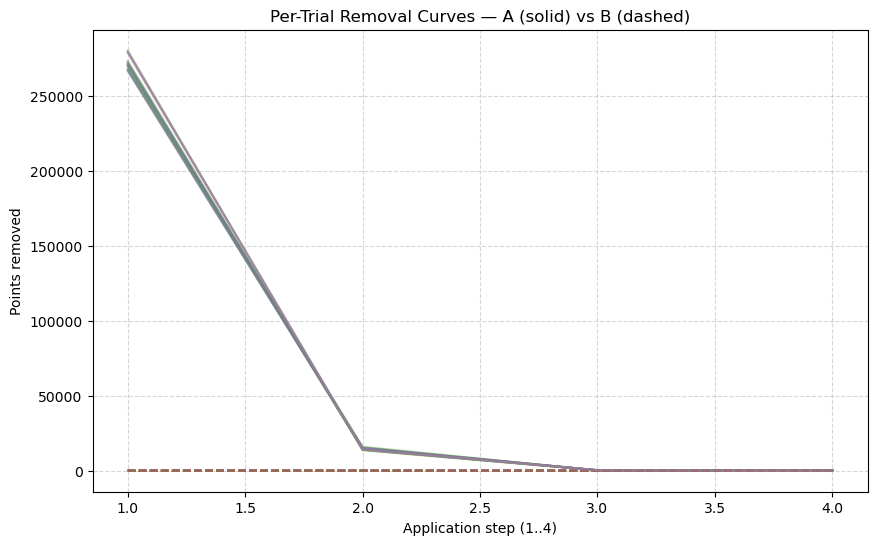

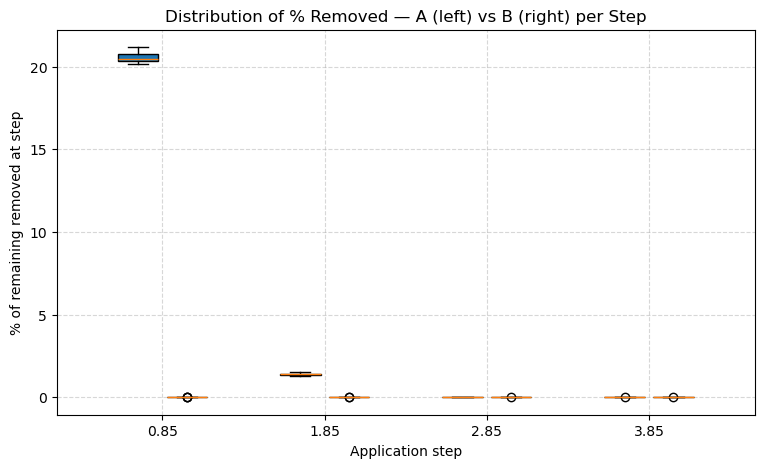

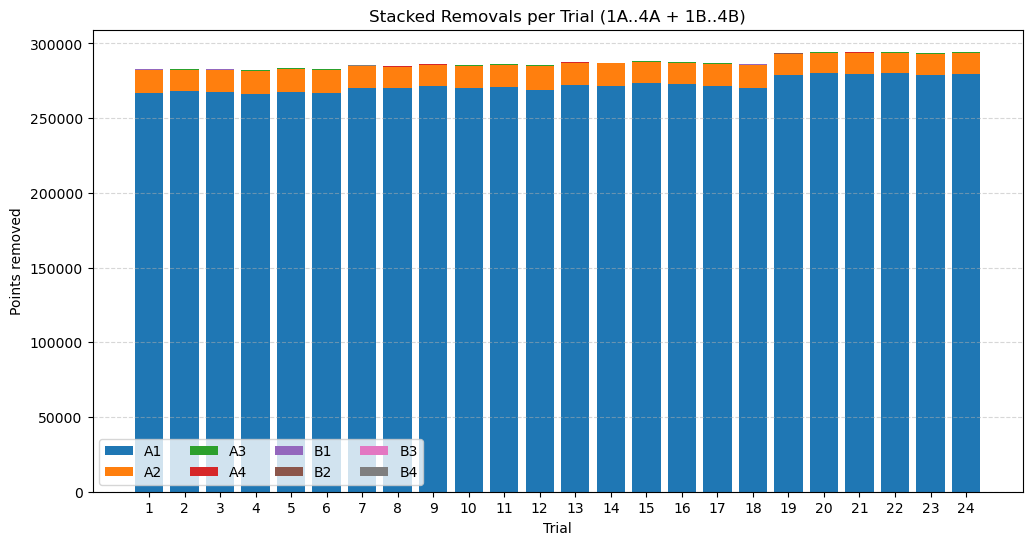


Done. All PLYs are organized under: /Users/dnatekar82/Desktop/venv/trial_outputs


In [3]:
# === KNN Trial/Application Program: 24 trials × (1a..4a + 1b..4b) ===
# Robust to blank/NaN cells in the "b" block (auto-fills from "a")
# Saves PLYs to trial_outputs/TrialXX/, writes a CSV, and renders inline plots

# ---------------------------- CONFIG ----------------------------
ORIGINAL_PLY        = "jay-willoughby.ply"
REF_KEEP_PLY        = "manual-filtering.ply"      # manually cleaned "ideal"
REF_NOISE_PLY       = "jw-noise-points.ply"       # manual noise-only sample
TRIALS_XLSX         = "divya trials.xlsx"         # professor’s schedule

OUT_ROOT            = "trial_outputs"             # root for all outputs
VOXEL_SIZE          = 0.10                        # base voxel for speed
FOV_DEFAULT         = 95.0                        # degrees
MATCH_RADIUS        = 0.08                        # label radius (m)
KNN_K               = 15
KNN_WEIGHTS         = "distance"                  # 'distance' or 'uniform'
KNN_ALGO            = "kd_tree"
KNN_LEAF            = 40
MAX_TRAIN_SAMPLES   = 200_000                     # balanced cap per pass
ROI_FOCUS           = 3.0                         # emphasis inside current FOV
FEAT_K              = 16                          # neighbors for normals/density

RANSAC_DIST_THRESH  = 0.05
RANSAC_N            = 3
RANSAC_ITERS        = 1000
RANDOM_STATE        = 42

# --------------------------- IMPORTS ----------------------------
import os, math, time
from pathlib import Path
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree, NearestNeighbors, KNeighborsClassifier
from IPython.display import display

np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)

# ------------------------- UTIL FUNCTIONS -----------------------
def ensure_dir(p): Path(p).mkdir(parents=True, exist_ok=True)

def load_ply(path):
    pcd = o3d.io.read_point_cloud(path)
    if pcd.is_empty():
        raise ValueError(f"Empty/unreadable PLY: {path}")
    return pcd

def voxel_downsample(pcd, v):
    return pcd.voxel_down_sample(voxel_size=v) if v and v>0 else pcd

def estimate_normals(pcd, k=16):
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn=k))
    pcd.normalize_normals(); return pcd

def segment_dominant_plane(pcd, distance_threshold, ransac_n, num_iterations):
    return pcd.segment_plane(distance_threshold, ransac_n, num_iterations)

def local_density_feature(points, k=16):
    nn = NearestNeighbors(n_neighbors=k); nn.fit(points)
    dists, _ = nn.kneighbors(points)
    mean_d = dists[:, 1:].mean(axis=1)
    return 1.0 / (mean_d + 1e-9)

def build_features(pcd, ground_plane=None, k=16):
    pts = np.asarray(pcd.points)
    if ground_plane is not None:
        a,b,c,d = ground_plane
        denom = math.sqrt(a*a + b*b + c*c) + 1e-9
        height = (a*pts[:,0] + b*pts[:,1] + c*pts[:,2] + d) / denom
    else:
        height = pts[:,2]
    if not pcd.has_normals():
        estimate_normals(pcd, k=k)
    normals = np.asarray(pcd.normals)
    abs_nz = np.abs(normals[:,2])
    density = local_density_feature(pts, k=k)
    return np.c_[height, density, abs_nz]

def inward_fov_mask(pts_xy, corner_idx, bbox, fov_deg=90.0):
    xmin, ymin, xmax, ymax = bbox
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    if   corner_idx == 1: sx, sy = xmin, ymax
    elif corner_idx == 2: sx, sy = xmax, ymax
    elif corner_idx == 3: sx, sy = xmax, ymin
    elif corner_idx == 4: sx, sy = xmin, ymin
    else: raise ValueError("corner_idx must be 1..4")
    look = np.array([cx - sx, cy - sy]); look /= (np.linalg.norm(look)+1e-12)
    vecs = pts_xy - np.array([sx, sy]); vnorm = np.linalg.norm(vecs, axis=1) + 1e-12
    dots = (vecs * look).sum(axis=1) / vnorm
    half_cos = math.cos(math.radians(fov_deg/2.0))
    return (dots >= half_cos) & (dots > 0)

def label_from_refs(pts, keep_tree, noise_tree, r, kd=None, nd=None):
    N = len(pts)
    labels = np.full(N, -1, dtype=np.int8)
    keep_hits  = keep_tree.query_radius(pts, r=r)  if keep_tree  is not None else [()] * N
    noise_hits = noise_tree.query_radius(pts, r=r) if noise_tree is not None else [()] * N
    for i in range(N):
        hk = len(keep_hits[i])  > 0
        hn = len(noise_hits[i]) > 0
        if hk and not hn: labels[i] = 1
        elif hn and not hk: labels[i] = 0
        elif hk and hn and (kd is not None) and (nd is not None):
            if kd[i] < 0.95 * nd[i]: labels[i] = 1
            elif nd[i] < 0.95 * kd[i]: labels[i] = 0
    return labels

def roi_weighted_sample(idx_pos, idx_neg, roi_mask, max_total, roi_focus=3.0):
    pos_roi = np.intersect1d(idx_pos, np.where(roi_mask)[0])
    pos_non = np.setdiff1d(idx_pos, pos_roi)
    neg_roi = np.intersect1d(idx_neg, np.where(roi_mask)[0])
    neg_non = np.setdiff1d(idx_neg, neg_roi)
    per_class = max_total // 2

    def choose(arr, k):
        if k <= 0: return np.array([], dtype=int)
        if len(arr) <= k: return arr
        return rng.choice(arr, size=k, replace=False)

    def split_counts(n_roi, n_non, total, focus):
        roi_t = int(min(n_roi, round(total * focus / (focus+1.0))))
        non_t = int(min(n_non, total - roi_t))
        if roi_t + non_t < total:
            extra = total - (roi_t + non_t)
            add_roi = min(extra, n_roi - roi_t); roi_t += add_roi; extra -= add_roi
            non_t += min(extra, n_non - non_t)
        return roi_t, non_t

    p_roi_t, p_non_t = split_counts(len(pos_roi), len(pos_non), per_class, roi_focus)
    n_roi_t, n_non_t = split_counts(len(neg_roi), len(neg_non), per_class, roi_focus)
    pos_sel = np.concatenate([choose(pos_roi, p_roi_t), choose(pos_non, p_non_t)])
    neg_sel = np.concatenate([choose(neg_roi, n_roi_t), choose(neg_non, n_non_t)])
    return pos_sel, neg_sel

def predict_batches(clf, X, batch=250_000):
    N = len(X); out = np.empty(N, dtype=int)
    for s in range(0, N, batch):
        e = min(N, s+batch); out[s:e] = clf.predict(X[s:e])
    return out

# ----------------------- ROBUST SCHEDULE READER -----------------
def load_trial_schedule(xlsx):
    """
    Robust schedule reader for your Excel (tolerates blank/NaN in B-block).
    Returns dict:
      schedule[trial] = {'a':[c1..c4], 'b':[c1..c4]} with integers in {1,2,3,4}
    """
    import numpy as np
    df = pd.read_excel(xlsx, sheet_name=0, header=None)

    # Find A-block anchor row containing "application 1a"
    a_start = None
    for i in range(len(df)):
        row_str = " ".join(str(x).lower() for x in df.iloc[i].tolist())
        if "application 1a" in row_str:
            a_start = i; break
    if a_start is None:
        raise ValueError("Could not find 'application 1a' block in the Excel.")

    a_rows = [a_start + j for j in range(4)]  # rows for 1a..4a

    # Find B-block anchor row containing "application 1b" (optional)
    b_start = None
    for i in range(a_rows[-1] + 1, len(df)):
        row_str = " ".join(str(x).lower() for x in df.iloc[i].tolist())
        if "application 1b" in row_str:
            b_start = i; break
    b_rows = [b_start + j for j in range(4)] if b_start is not None else None

    # Header row with "Trial 1 ... Trial 24"
    header_row = a_start - 1 if a_start - 1 >= 0 else a_start
    trials = []
    for j, val in enumerate(df.iloc[header_row].tolist()):
        s = str(val).strip().lower()
        if s.startswith("trial"):
            try:
                tnum = int(s.replace("trial", "").strip())
                trials.append((j, tnum))
            except:
                pass
    if not trials:
        raise ValueError("Could not find 'Trial' columns in the Excel.")

    # Helper: parse a corner cell into {1,2,3,4} or None
    def parse_corner(cell):
        if cell is None: return None
        if isinstance(cell, float) and np.isnan(cell): return None
        s = str(cell).strip().lower()
        s = s.replace("corner ", "").replace("corner", "")
        try:
            v = int(float(s))
            return v if v in (1,2,3,4) else None
        except:
            return None

    # Initialize schedule
    schedule = {tnum: {"a":[None]*4, "b":[None]*4} for _, tnum in trials}

    # Fill A-block (required)
    for step in range(4):  # steps 1..4
        row_vals = df.iloc[a_rows[step]].tolist()
        for col, tnum in trials:
            c = parse_corner(row_vals[col])
            if c not in (1,2,3,4):
                raise ValueError(f"Trial {tnum}: invalid A-step corner: {row_vals[col]}")
            schedule[tnum]["a"][step] = c

    # Fill B-block (tolerant; missing/NaN → copy A-step)
    if b_rows is not None:
        for step in range(4):
            row_vals = df.iloc[b_rows[step]].tolist()
            for col, tnum in trials:
                c = parse_corner(row_vals[col])
                schedule[tnum]["b"][step] = c if c in (1,2,3,4) else schedule[tnum]["a"][step]
    else:
        # No B-block at all → copy A-seq
        for tnum in schedule:
            schedule[tnum]["b"] = schedule[tnum]["a"][:]

    # Final sanity
    for tnum in schedule:
        for phase in ("a","b"):
            for i in range(4):
                if schedule[tnum][phase][i] not in (1,2,3,4):
                    schedule[tnum][phase][i] = schedule[tnum]["a"][i]

    return schedule

# ------------------------------ RUN -----------------------------
t0 = time.time()
ensure_dir(OUT_ROOT)

# Load main cloud & references
pcd0 = load_ply(ORIGINAL_PLY)
pcd0 = voxel_downsample(pcd0, VOXEL_SIZE)
estimate_normals(pcd0, k=FEAT_K)
plane_model, inliers = segment_dominant_plane(pcd0, RANSAC_DIST_THRESH, RANSAC_N, RANSAC_ITERS)
pts0 = np.asarray(pcd0.points)
xmin, ymin = pts0[:,0].min(), pts0[:,1].min()
xmax, ymax = pts0[:,0].max(), pts0[:,1].max()
BBOX = (xmin, ymin, xmax, ymax)
print("Ground plane:", np.round(plane_model, 4), "| inliers:", len(inliers))

ref_keep  = load_ply(REF_KEEP_PLY)
ref_noise = load_ply(REF_NOISE_PLY)
keep_pts  = np.asarray(ref_keep.points)
noise_pts = np.asarray(ref_noise.points)
keep_tree  = KDTree(keep_pts)  if keep_pts.size  else None
noise_tree = KDTree(noise_pts) if noise_pts.size else None

# Precompute nearest distances on original space (tie-breaks)
if keep_tree is not None and noise_tree is not None:
    kd, _ = keep_tree.query(pts0,  k=1, return_distance=True); kd = kd.reshape(-1)
    nd, _ = noise_tree.query(pts0, k=1, return_distance=True); nd = nd.reshape(-1)
else:
    kd = nd = None

# Read schedule (tolerant reader)
schedule = load_trial_schedule(TRIALS_XLSX)
n_trials = len(schedule)
print(f"Loaded schedule for {n_trials} trials (expect 24).")

# Storage for report
rows = []   # trial, phase, step, corner, kept_after, removed_step, removed_pct

# ---- Helper: phase runner returns updated pcd_trial (no nonlocal) ----
def run_phase(pcd_trial, phase_name, corners_seq):
    for step_idx, corner in enumerate(corners_seq, start=1):
        label = f"{phase_name}{step_idx}"   # 'a1'..'a4' or 'b1'..'b4'
        print(f"-- Application {label} (corner {corner})")

        X = build_features(pcd_trial, ground_plane=plane_model, k=FEAT_K)
        pts = np.asarray(pcd_trial.points)
        if len(pts) == 0:
            print("   No points left; skipping remaining steps in this phase.")
            rows.append([tnum, phase_name, step_idx, corner, 0, 0, 0.0])
            continue

        roi = inward_fov_mask(pts[:, :2], corner, BBOX, fov_deg=FOV_DEFAULT)

        labels = label_from_refs(
            pts, keep_tree, noise_tree, MATCH_RADIUS,
            kd=kd[:len(pts)] if kd is not None else None,
            nd=nd[:len(pts)] if nd is not None else None
        )
        idx_keep  = np.where(labels == 1)[0]
        idx_noise = np.where(labels == 0)[0]

        sel_pos, sel_neg = roi_weighted_sample(idx_keep, idx_noise, roi_mask=roi,
                                               max_total=MAX_TRAIN_SAMPLES, roi_focus=ROI_FOCUS)
        train_idx = np.concatenate([sel_pos, sel_neg])
        if train_idx.size < 10:
            pool = np.concatenate([idx_keep, idx_noise])
            take = min(len(pool), MAX_TRAIN_SAMPLES)
            if take == 0:
                keep_ix = np.arange(len(pts)); rem_ix = np.array([], dtype=int)
            else:
                train_idx = rng.choice(pool, size=take, replace=False)

        if train_idx.size >= 10:
            clf = KNeighborsClassifier(
                n_neighbors=KNN_K,
                weights=KNN_WEIGHTS,
                algorithm=KNN_ALGO,
                leaf_size=KNN_LEAF,
                n_jobs=-1
            )
            clf.fit(X[train_idx], labels[train_idx].astype(int))
            y_pred = predict_batches(clf, X, batch=250_000)
            keep_ix = np.where(y_pred == 1)[0]
            rem_ix  = np.where(y_pred == 0)[0]

        kept_after   = keep_ix.size
        removed_step = rem_ix.size
        removed_pct  = (removed_step / (removed_step + kept_after)) * 100.0 if (removed_step + kept_after) > 0 else 0.0
        rows.append([tnum, phase_name, step_idx, corner, kept_after, removed_step, removed_pct])

        # Save PLYs for this step
        out_keep = trial_dir / f"trial{tnum:02d}_app{label}_remaining.ply"
        out_rem  = trial_dir / f"trial{tnum:02d}_app{label}_removed.ply"
        o3d.io.write_point_cloud(str(out_keep), pcd_trial.select_by_index(keep_ix))
        if rem_ix.size > 0:
            o3d.io.write_point_cloud(str(out_rem),  pcd_trial.select_by_index(rem_ix))

        # Cascade remaining to next application
        pcd_trial = pcd_trial.select_by_index(keep_ix)
    return pcd_trial

# -------------------------- MAIN LOOP ---------------------------
for tnum in range(1, n_trials+1):
    print(f"\n====== Trial {tnum:02d} ======")
    trial_dir = Path(OUT_ROOT) / f"Trial{tnum:02d}"
    ensure_dir(trial_dir)

    # Start each trial from the same original voxelised cloud
    pcd_trial = o3d.geometry.PointCloud(pcd0)  # copy for this trial

    # Phase A (1a..4a)
    pcd_trial = run_phase(pcd_trial, 'a', schedule[tnum]['a'])
    # Phase B (1b..4b), starting from remaining after 4a
    pcd_trial = run_phase(pcd_trial, 'b', schedule[tnum]['b'])

# ------------------------ SUMMARY TABLE/CSV ---------------------
df = pd.DataFrame(rows, columns=[
    "trial","phase","step","corner","kept_after","removed_step","removed_pct_of_remaining"
])
display(df.head(16))
csv_path = Path(OUT_ROOT) / "trial_removal_summary.csv"
df.to_csv(csv_path, index=False)
print(f"\nSaved summary CSV → {csv_path.resolve()}")

# ---------------------------- PLOTS -----------------------------
# 1) Removal curves per trial: A vs B (steps 1..4)
plt.figure(figsize=(10,6))
for t in sorted(df['trial'].unique()):
    a = df[(df.trial==t)&(df.phase=='a')].sort_values('step')['removed_step'].to_numpy()
    b = df[(df.trial==t)&(df.phase=='b')].sort_values('step')['removed_step'].to_numpy()
    if a.size==4:
        plt.plot([1,2,3,4], a, alpha=0.35)                 # A-phase (solid)
    if b.size==4:
        plt.plot([1,2,3,4], b, alpha=0.35, linestyle="--") # B-phase (dashed)
plt.title("Per-Trial Removal Curves — A (solid) vs B (dashed)")
plt.xlabel("Application step (1..4)"); plt.ylabel("Points removed")
plt.grid(True, linestyle="--", alpha=0.5); plt.show()

# 2) Percent removals per step (boxplots for distribution over 24 trials)
plt.figure(figsize=(9,5))
for idx, phase in enumerate(['a','b']):
    y = [df[(df.phase==phase)&(df.step==s)]['removed_pct_of_remaining'].to_numpy() for s in [1,2,3,4]]
    pos = np.array([1,2,3,4]) + (0.15 if phase=='b' else -0.15)
    plt.boxplot(y, positions=pos, widths=0.25, patch_artist=True)
plt.title("Distribution of % Removed — A (left) vs B (right) per Step")
plt.xlabel("Application step"); plt.ylabel("% of remaining removed at step")
plt.grid(True, linestyle="--", alpha=0.5); plt.xticks([1,2,3,4]); plt.show()

# 3) Stacked bars per trial (8 apps)
series = {}
for label in [('a',1),('a',2),('a',3),('a',4),('b',1),('b',2),('b',3),('b',4)]:
    phase, step = label
    key = f"{phase}{step}"
    series[key] = df[(df.phase==phase)&(df.step==step)].sort_values('trial')['removed_step'].to_numpy()

trials_sorted = sorted(df['trial'].unique())
x = np.arange(len(trials_sorted))
bottom = np.zeros_like(x, dtype=float)
plt.figure(figsize=(12,6))
for key in ["a1","a2","a3","a4","b1","b2","b3","b4"]:
    vals = series.get(key, np.zeros_like(x))
    plt.bar(x, vals, bottom=bottom, label=key.upper())
    bottom += vals
plt.title("Stacked Removals per Trial (1A..4A + 1B..4B)")
plt.xlabel("Trial"); plt.ylabel("Points removed"); plt.xticks(x, trials_sorted)
plt.grid(True, axis="y", linestyle="--", alpha=0.5); plt.legend(ncol=4); plt.show()

print("\nDone. All PLYs are organized under:", Path(OUT_ROOT).resolve())
